# 2D MoM for Rectangular Plate 

## Import Packages

In [1]:
using ForwardDiff
using QuadGK
using HCubature 
using StaticArrays 
using LinearAlgebra 
using BenchmarkTools
using Plots

In [2]:
# a point in 3D is a tuple of 3 coordinates 
# we here introduce static vectors that appear to be vital to reduce the number of allocations 
const Point3D = SVector{3,Float64};

## Section 1: Introduction 

The <b>goal</b> here is to arrive a small proof-of-concept MoM using AD and quadrature for the 2D rectangular plate geometry. 

<b>To do</b>
1. add list of midpoint of edges to the mesh;
2. the number of midpint on horizontal (vertical) edges is equal to ex=(ny+1)*nx (ey=(nx+1)*ny)
3. each midpoint with have cartesian coordinate (i,j), a Point3D for spatial coordinates and a pair of neighbouring cells (owner and neighbour). Midpoints on the boundary are left without neighbour 

<b>Clarify 2 ne unknown (magnetization vector), and thus 2 ne equations (bx and by required)</b>

<b>Loop over internal horizontal (vertical) edges</b>

<b>Loop over boundary horizontal (vertical) edges</b>

<b>Does Meshes.jl (CartesianGrid?) provide suppoort for faces-element connectivity</b>
1. grid = CartesianGrid(10,10) # generates grid 
2. faces(grid) # shows all the faces 
3. How to build the face-element connectivity? How to loop over faces? 

<b>Finite Difference Computation of the Magntic Flux Given the Vector Potential</b>

<b>ForwardDiff applied over function defined in terms of map as a function of the magnetization</b>

<b>Remark</b>
1. We integrate the singular kernel in <b>three (3)</b> spatial dimensions. This renders the singularity of the kernel easier to handle. The disavantagof this approach is that the kernel of the vector potential has three non-zeros components. Indeed, while the magnetization vector has a zero z-component (in plane magnmetization), the position vector from source to destination has three (3) non-zero components;
2. We employ same integration accuracy for self and non-self elements; 
3. We wish to obtain numbr of statistics of number of function calls; 

<b>Use of Julia</b>

In [3]:
# use of the macro @view 
m = [1;2;3;4]
m1 = @view m[1:2]
m2 = @view m[3:4]
m2[1]

3

In [4]:
# use the function mapreduce() to 2D array of 3D-vectors
A = Array{Point3D}(undef,2,2)
A[1,1] = Point3D(-1.,0.,0.)  
A[1,2] = Point3D(-2.,0.,0.)
A[2,1] = Point3D(-1.,0.,0.)  
A[2,2] = Point3D(-2.,0.,0.)
A

map(x->2*x,A)

mapreduce(x->2*x,+,A)

3-element SVector{3, Float64} with indices SOneTo(3):
 -12.0
   0.0
   0.0

## Section 2: Struct Definition for Element and Mesh 

### Section 1.2: Data Structures for Q0 rectangular elements 

1. uniform mesh consisting of $ne = nx \cdot ny$ 3D hexahedral elements with constant thickness;
2. $mx$: vector of $ne$ elements holding constant value of magnetization in $x$-direction; 
3. $my$: vector of $ne$ elements holding constant value of magnetization in $y$-direction;
4. $m = [mx, my]$: vector formed by concatenation of $mx$ and $my$; 
5. $(i,j)$: tuple coding $i$th-$j$th-element in the mesh for $1 \leq i \leq nx$ and $1 \leq j \leq ny$;
6. $I = nx*(j-1)+i$: linearization of $(i,j)$ tuple to retrieve information from the vector $mx$ and $my$; 

In [12]:
# struct to hold a single mesh element
struct Element
  p1::Point3D                  # middle-lower-front node of the block 
  p2::Point3D                  # right-middle-front node of the block  
  p3::Point3D                  # middle-upper-front node of the block 
  p4::Point3D                  # left-middle-front node of the block    
  i::Int64                     # global index first node
  j::Int64                     # global index second node
  I::Int64                     # global index third node
  xs::Float64                  # left (start) point of the element 
  ys::Float64                  # lower (start) point of the element 
  zs::Float64                  # front (start) point of the element     
  xe::Float64                  # right (end) point of the element 
  ye::Float64                  # top (end) point of the element  
  ze::Float64                  # back (end) point of the element       
end

# struct to hold  midpoints of horizontally (x-direction) oriented faces 
struct xFace 
    p1::Point3D                # midpoint of face  
end 

# struct to hold  midpoints of vertically (y-direction) oriented faces
struct yFace 
    p1::Point3D                # midpoint of face  
end 

# struct to hold entire mesh
struct Mesh
  nx::Int64                    # number of elements in the x-direction 
  ny::Int64                    # number of elements in the y-direction
  ne::Int64                    # total number of elements
  Elements::Array{Element,2}   # two-dimensional array of type Element 
  xFaces::Array{xFace,2}       # two-dimensional array of type xFace 
  yFaces::Array{yFace,2}       # two-dimensional array of type yFace     
end

In [13]:
#..sets the mesh with nx * ny elements 
function generate_mesh(nx,ny)
    
    #..set mesh spacings 
    hx = 2/nx; hy = 2/ny;  
    
    #..set thickness ion the z-direction
    thickness = 0.1
    
    #..initialized array of nx-by-ny of type Element  
    Elements = Array{Element}(undef,nx,ny)

    #..set Elements by loop over elements in the mesh.. 
    for i=1:nx 
        xs = -1+(i-1)*hx; xe = xs+hx 
        for j=1:ny 
            ys = -1+(j-1)*hy; ye = ys+hy
            I  = nx*(j-1)+i 
            p1 = Point3D(xs+hx/2,ys,0)
            p2 = Point3D(xe,ys+hy/2,0)
            p3 = Point3D(xs+hx/2,ys,0)
            p4 = Point3D(xs,ys+hy/2,0)
            Elements[i,j] = Element(p1,p2,p3,p4,i,j,I,xs,ys,0,xe,ye,thickness)
        end 
    end
    
    #..initialized array of nx-by-(ny+1) of type xFace   
    xFaces = Array{xFace}(undef,nx,ny+1)

    #..set xFaces by loop over horizontal faces in the mesh.. 
    for i=1:nx 
        xs = -1+(i-1)*hx
        for j=1:ny+1
            ys = -1+(j-1)*hy
            p1 = Point3D(xs+hx/2,ys,0)
            xFaces[i,j] = xFace(p1)
        end 
    end
    
    #..initialized array of (nx+1)-by-ny of type yFace   
    yFaces = Array{yFace}(undef,nx+1,ny)

    #..set xFaces by loop over horizontal faces in the mesh.. 
    for i=1:nx+1
        xs = -1+(i-1)*hx
        for j=1:ny
            ys = -1+(j-1)*hy
            p1 = Point3D(xs,ys+hy/2,0)
            yFaces[i,j] = yFace(p1)
        end 
    end    

    #..set DOF per element
    ne = nx*ny  
    
    #..Store data inside mesh struct  
    mesh = Mesh(nx,ny,ne,Elements,xFaces,yFaces) 

    return mesh 
end 

mesh = generate_mesh(2,2)
element = mesh.Elements[2,2]
xface = mesh.xFaces[2,2]

xFace([0.5, 0.0, 0.0])

## Section 3: Generate Mesh 

In [14]:
# input for sample call 
nx=100; ny=100;
mesh = generate_mesh(nx,ny);

## Section 4: Set Magnetization on Mesh

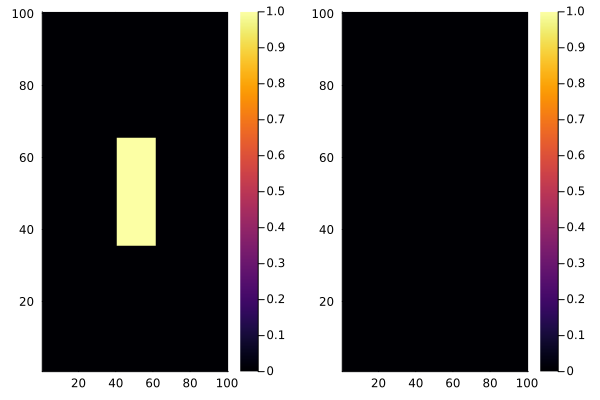

In [15]:
function set_magnization(element)
    p1 = element.p1
    xbound = abs(p1.x)<0.3
    ybound = abs(p1.y)<0.2 
    inPlate = xbound*ybound
    inAir   = 1-inPlate 
    mx = 1.0*inPlate; my = 0 
    return SVector{3,Float64}(mx,my,0)
end 

M = map(element -> set_magnization(element), mesh.Elements)

# postprocessing 
Mx = map(v->v.x, M)
My = map(v->v.y, M)

p1 = heatmap(Mx) 
p2 = heatmap(My)
plot(p1,p2)

## Section 5: All Functions

To further specify input, output and input-output relation for all functions. 

In [31]:
#..sets magnitization on single source element
function magnetization(elementp,M)
    I = elementp.I  
    ne = div(length(M),2)
    mx = @view M[1:ne]
    my = @view M[ne+1:2*ne]
    return SVector{3,Float64}(mx[I],my[I],0)
end

#..sets vp_kernel on single source element
function vp_kernel(r,rp,elementp,M) 
    Mp  = magnetization(elementp,M)
    num = cross(Mp, (r - rp))
    denom = norm(r - rp)^3
    result = num/denom
    return result   
end 

#..sets vp contribution on source element by cubature of vp_density 
function vp_source(face,elementp,mesh,M)
    r  = face.p1
    (; p1, i, j, I, xs, ys, zs, xe, ye, ze) = elementp 
    xm = (xs+xe)/2; ym = (ys+ye)/2 
    # vp_src = SVector{3,Float64}(0,0,0) 
    vp_src = hcubature(rp -> vp_kernel(r,rp,elementp,M), (xs,ys,zs), (xm,ym,ze))[1]
    vp_src += hcubature(rp -> vp_kernel(r,rp,elementp,M), (xs,ym,zs), (xm,ye,ze))[1]
    vp_src += hcubature(rp -> vp_kernel(r,rp,elementp,M), (xm,ys,zs), (xe,ym,ze))[1]
    vp_src += hcubature(rp -> vp_kernel(r,rp,elementp,M), (xm,ym,zs), (xe,ye,ze))[1]
end

#..set vp on destination element by mapreduce over all source elements  
function vp_destination(face,mesh,M) 
    vp_dest = mapreduce(elementp->vp_source(face,elementp,mesh,M),+,mesh.Elements)
end

#..set vp on mesh by map over all destination elements in the mesh 
function vp_xFaces(mesh,M)
    vpx = map(xface->vp_destination(xface,mesh,M),mesh.xFaces)
end 

#..set vp on mesh by map over all destination elements in the mesh 
function vp_yFaces(mesh,M)
    vpy = map(yface->vp_destination(yface,mesh,M),mesh.yFaces)
end 

vp_yFaces (generic function with 1 method)

## Section 6: Testing Individual Functions 

In [45]:
?zero

search: zero zeros ZeroPivotException iszero zerror zerror! set_zero_subnormals



```
zero(x)
zero(::Type)
```

Get the additive identity element for the type of `x` (`x` can also specify the type itself).

See also [`iszero`](@ref), [`one`](@ref), [`oneunit`](@ref), [`oftype`](@ref).

# Examples

```jldoctest
julia> zero(1)
0

julia> zero(big"2.0")
0.0

julia> zero(rand(2,2))
2×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0
```

---

```
zero(h::Histogram)
```

Create a new histogram with the same binning, type and shape of weights and the same properties (`closed` and `isdensity`) as `h`, with all weights set to zero.


In [48]:
#..sets magnitization on single source element
function magnetization(elementp,M)
    I = elementp.I  
    ne = div(length(M),2)
    mx = @view M[1:ne]
    my = @view M[ne+1:2*ne]
    # return SVector{3,Float64}(mx[I],my[I],zero(M))
    return (mx[I],my[I],zero(M))
    # return zeros(eltype(M), 3)
end

# input for sample call 
nx=3; ny=3;
mesh = generate_mesh(nx,ny)
ne = mesh.ne
M = ones(2*ne)

# sample call
mesh = generate_mesh(3,3)
element = mesh.Elements[2,2]
magnetization(element,M)
#@code_warntype magnetization(element,M)

(1.0, 1.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [50]:
M0 = M
Cp = ForwardDiff.gradient(M -> magnetization(element,M), M0)

LoadError: MethodError: no method matching zero(::Tuple{ForwardDiff.Dual{ForwardDiff.Tag{var"#153#154", Float64}, Float64, 9}, ForwardDiff.Dual{ForwardDiff.Tag{var"#153#154", Float64}, Float64, 9}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{var"#153#154", Float64}, Float64, 9}}})
[0mClosest candidates are:
[0m  zero([91m::Union{Type{P}, P}[39m) where P<:Dates.Period at /Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/Dates/src/periods.jl:53
[0m  zero([91m::ForwardDiff.Partials[39m) at ~/.julia/packages/ForwardDiff/PcZ48/src/partials.jl:39
[0m  zero([91m::ForwardDiff.Dual[39m) at ~/.julia/packages/ForwardDiff/PcZ48/src/dual.jl:357
[0m  ...

In [21]:
#..sets vp_kernel on single source element
function vp_kernel(r,rp,elementp,M) 
    Mp  = magnetization(elementp,M)
    num = cross(Mp, (r - rp))
    denom = norm(r - rp)^3
    result = num/denom
    return result   
end 

# input for sample call
nx=3; ny=3;   
mesh = generate_mesh(nx,ny)
ne = mesh.ne
M = ones(2*ne)

# sample call
element  = mesh.Elements[1,1]
r = element.p1 
elementp = mesh.Elements[2,2]
rp = Point3D((elementp.xs+elementp.xe)/2,(elementp.ys+elementp.ye)/2,(elementp.zs+elementp.ze)/2) 
vp_kernel(r,rp,elementp,M)
#@code_warntype vp_kernel(r,rp,elementp,M)

3-element SVector{3, Float64} with indices SOneTo(3):
 -0.028727128651401812
  0.028727128651401812
 -0.19151419100934536

In [34]:
#..sets vp contribution on source element by cubature of vp_density 
function vp_source(face,elementp,mesh,M)
    r  = face.p1
    (; p1, i, j, I, xs, ys, zs, xe, ye, ze) = elementp 
    xm = (xs+xe)/2; ym = (ys+ye)/2 
    # vp_src = SVector{3,Float64}(0,0,0) 
    vp_src = hcubature(rp -> vp_kernel(r,rp,elementp,M), (xs,ys,zs), (xm,ym,ze))[1]
    vp_src += hcubature(rp -> vp_kernel(r,rp,elementp,M), (xs,ym,zs), (xm,ye,ze))[1]
    vp_src += hcubature(rp -> vp_kernel(r,rp,elementp,M), (xm,ys,zs), (xe,ym,ze))[1]
    vp_src += hcubature(rp -> vp_kernel(r,rp,elementp,M), (xm,ym,zs), (xe,ye,ze))[1]
end

# input for sample call
nx=3; ny=3;   
mesh = generate_mesh(nx,ny)
ne = mesh.ne
M = ones(2*ne)

# sample call
xface    = mesh.xFaces[1,1]
elementp = mesh.Elements[1,1]
vp_source(xface,elementp,mesh,M)

3-element SVector{3, Float64} with indices SOneTo(3):
 -0.28108042220775237
  0.28108042220775237
 -0.48498457423271424

In [38]:
M0 = M
Cp = ForwardDiff.jacobian(M -> vp_source(xface,elementp,mesh,M), M0)

LoadError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{var"#145#146", Float64}, Float64, 9})
[0mClosest candidates are:
[0m  (::Type{T})(::Real, [91m::RoundingMode[39m) where T<:AbstractFloat at rounding.jl:200
[0m  (::Type{T})(::T) where T<:Number at boot.jl:772
[0m  (::Type{T})([91m::AbstractChar[39m) where T<:Union{AbstractChar, Number} at char.jl:50
[0m  ...

In [35]:
#..set vp on destination element by mapreduce over all source elements  
function vp_destination(face,mesh,M) 
    vp_dest = mapreduce(elementp->vp_source(face,elementp,mesh,M),+,mesh.Elements)
end

# input for sample call
nx=3; ny=3;   
mesh = generate_mesh(nx,ny)
ne = mesh.ne
M = ones(2*ne)

# sample call
xface   = mesh.xFaces[1,1]
vp_dest = vp_destination(xface,mesh,M)

3-element SVector{3, Float64} with indices SOneTo(3):
 -0.2952672225425233
  0.2952672225425233
 -0.5025415637130335

In [36]:
M0 = M
Cp = ForwardDiff.jacobian(M -> vp_destination(xface,mesh,M), M0)

LoadError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{var"#141#142", Float64}, Float64, 9})
[0mClosest candidates are:
[0m  (::Type{T})(::Real, [91m::RoundingMode[39m) where T<:AbstractFloat at rounding.jl:200
[0m  (::Type{T})(::T) where T<:Number at boot.jl:772
[0m  (::Type{T})([91m::AbstractChar[39m) where T<:Union{AbstractChar, Number} at char.jl:50
[0m  ...

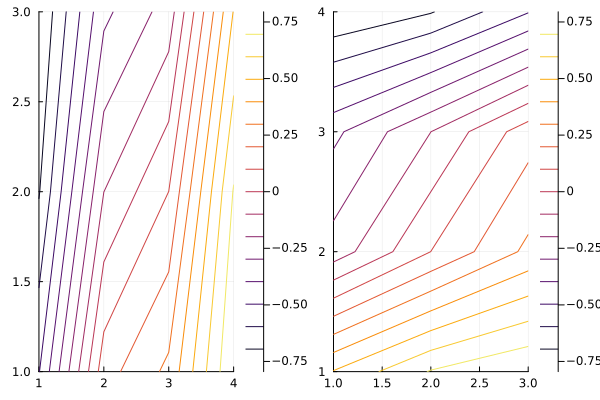

In [25]:
function vp_xFaces(mesh,M)
    vpx = map(xface->vp_destination(xface,mesh,M),mesh.xFaces)
end 

#..set vp on mesh by map over all destination elements in the mesh 
function vp_yFaces(mesh,M)
    vpy = map(yface->vp_destination(yface,mesh,M),mesh.yFaces)
end 

# input for sample call
nx=3; ny=3;   
mesh = generate_mesh(nx,ny)
ne = mesh.ne
M = ones(2*ne)

# sample call
vpx = vp_xFaces(mesh,M)
vpy = vp_yFaces(mesh,M)

# postprocessing 
Az_xFaces = map(v->v.z, vpx)
Az_yFaces = map(v->v.z, vpy)

p1 = contour(Az_xFaces) 
p2 = contour(Az_yFaces)
plot(p1,p2)

## Section 7: Apply to 2D Thin Plate 

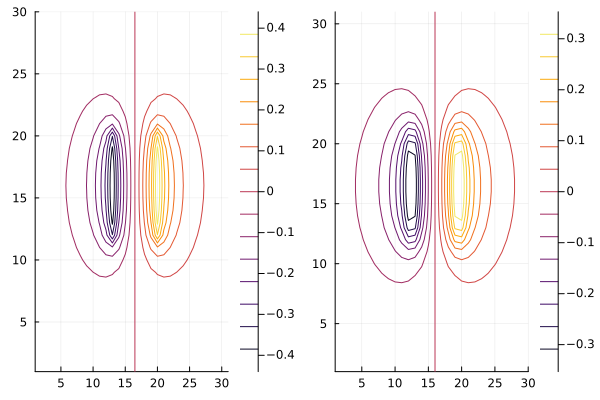

In [29]:
# input for sample call 
nx=30; ny=30;
mesh = generate_mesh(nx,ny);

M_array = map(element -> set_magnization(element), mesh.Elements)

mx = vec(map(v->v.x, M_array)); my = vec(map(v->v.y, M_array));  M = [mx;my]

vpx = vp_xFaces(mesh,M)
vpy = vp_yFaces(mesh,M)

# postprocessing 
Az_xFaces = map(v->v.z, vpx)
Az_yFaces = map(v->v.z, vpy)

p1 = contour(Az_xFaces) 
p2 = contour(Az_yFaces)
plot(p1,p2)

## Section 8: Using ForwardDiff  

In [32]:
M0 = M
Cp = ForwardDiff.jacobian(M -> vp_xFaces(mesh,M), M0)

LoadError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{var"#127#128", Float64}, Float64, 12})
[0mClosest candidates are:
[0m  (::Type{T})(::Real, [91m::RoundingMode[39m) where T<:AbstractFloat at rounding.jl:200
[0m  (::Type{T})(::T) where T<:Number at boot.jl:772
[0m  (::Type{T})([91m::AbstractChar[39m) where T<:Union{AbstractChar, Number} at char.jl:50
[0m  ...

In [ ]:
function prova(mesh,M)
    map(x->x.p1,mesh.Elements)
end

prova(mesh,M)

ForwardDiff.jacobian(M -> prova(mesh,M), M0)